<a href="https://colab.research.google.com/github/oscarfdezmora/EOI_Master_DSc/blob/main/Beer_advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src='https://sedigitalylanzate.es/wp-content/uploads/2019/03/logoeoiok-e1552040050697.png' width="500"></center>

# Ejercicio de algoritmo de filtro colaborativo

El objetivo de este ejercicio es generar un algoritmo de filtro colaborativo con los datos del dataset beer_review. La información se corresponde con la reviews de la web https://www.beeradvocate.com/

<center><img src='https://www.pngitem.com/pimgs/m/39-394080_beer-advocate-hd-png-download.png' width=600 ></center>

## Información

Este dataset consiste en revisiones de cerveza de Beeradvocate. Los datos abarcan un período de más de 10 años, que incluye todas ~ 1.5 millones de revisiones hasta noviembre de 2011. Cada revisión incluye calificaciones en términos de cinco "aspectos": apariencia, aroma, paladar, sabor e impresión general. Las revisiones incluyen información del producto y del usuario, seguida de cada una de estas cinco clasificaciones, y una revisión en formato texto. 

Para nuestro ejercicio vamos a usar una versión reducida de este dataset, que contiene las reviews de aquellos usuarios que han valorado al menos 50 cervezas.

## Pasos a seguir

1. Descarga la información de beeradvocate en una carpeta que se llame `datos_ejercicios/beeradvocate` y que se encuentre al mismo nivel que el notebook en el que vas a ejecutar el código.

2. Lee el fichero `beer_reviews_50.csv` y crea dos datasets:
    - uno con las reviews de los usuarios.
    - otro con la información de la cerveza (brewery, beer_name, beer_style)
    
3. Divide la información en los conjuntos de train y test.

4. De los distintos tipos de algoritmos que conocemos elige uno para generar la recomendación. Si creas más de uno explica el motivo de tu elección.


5. Crea una función que dado un usuario nos devuelva el top 10 de recomendaciones. 

6. Genera un html con los resultados de notebook file -> Export Notebook As... -> Export Notebook as HTML. Este html será el documento que tendrás que entregar para la evaluación del ejercicio.



---

---





In [ ]:
## Habilitamos la lectura desde Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Importamos las librerías
import pandas as pd

In [ ]:
## Definimos nuestra ruta de trabajo
dir = '/content/drive/MyDrive/Máster EOI/Semana 11 - Recomendadores/datos_ejercicios/beeradvocate/'

## Leemos los datos del fichero origen
datos = pd.read_csv(dir + 'beer_reviews_50.csv')
datos

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986.0
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213.0
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215.0
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969.0
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256591,870,Moylan's Brewery,1231487618,4.5,4.0,3.5,Jmoore50,American IPA,4.0,4.5,India Pale Ale,6.5,3064.0
256592,870,Moylan's Brewery,1231184213,4.0,3.5,4.0,kmeves,American IPA,3.0,3.5,India Pale Ale,6.5,3064.0
256593,870,Moylan's Brewery,1230947306,4.0,4.5,4.5,tavernjef,American IPA,4.5,4.0,India Pale Ale,6.5,3064.0
256594,870,Moylan's Brewery,1230365245,3.5,4.0,3.5,biboergosum,American IPA,4.0,4.0,India Pale Ale,6.5,3064.0


In [ ]:
## Creamos el data ser de cervezas
beers = datos[['beer_beerid','brewery_name','beer_name','beer_style']]
beers.head()

,beer_beerid,brewery_name,beer_name,beer_style
0,47986.0,Vecchio Birraio,Sausa Weizen,Hefeweizen
1,48213.0,Vecchio Birraio,Red Moon,English Strong Ale
2,48215.0,Vecchio Birraio,Black Horse Black Beer,Foreign / Export Stout
3,47969.0,Vecchio Birraio,Sausa Pils,German Pilsener
4,64883.0,Caldera Brewing Company,Cauldron DIPA,American Double / Imperial IPA


In [ ]:
## Creamos el data set de reviews
reviews = datos[['beer_beerid','review_overall','review_aroma','review_appearance','review_palate','review_taste', 'review_profilename']]
reviews.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,review_profilename
0,47986.0,1.5,2.0,2.5,1.5,1.5,stcules
1,48213.0,3.0,2.5,3.0,3.0,3.0,stcules
2,48215.0,3.0,2.5,3.0,3.0,3.0,stcules
3,47969.0,3.0,3.0,3.5,2.5,3.0,stcules
4,64883.0,4.0,4.5,4.0,4.0,4.5,johnmichaelsen


Tenemos cinco tipos de notas


* **review_aroma**, **review_appearance**, **review_palate**, **review_taste**, que son valoraciones para aspectos concretos de la cerveza
* **review_overall**, que contiene la evaluación final (que no siempre se puede corresponder con la media de las anteriores evaluaciones)

Si utilizamos solo review_overall, perderíamos parte de la información de las otras variables. 

Por ello, en un acto espléndido (y quizá de nulo impacto sobre el modelo ^^'), crearemos una nueva variable que conjugue las cinco, que llamaremos **review_trns**, que se creará:

*   con un **60%** del peso de **review_overall**
*   con un **40%** del **promedio de las otras variables**


In [ ]:
## Añadimos la columna review_trns con la formula anteriormente descrita
reviews['review_trns'] = reviews.apply(lambda row: 0.6*row['review_overall'] + 0.4*((row['review_aroma'] + row['review_appearance'] + row['review_palate'] + row['review_taste'])/4), axis=1)

## Podemos eliminar el resto de columnas de review
reviews = reviews.drop(['review_overall','review_aroma','review_appearance','review_palate','review_taste'], axis=1)
reviews.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,beer_beerid,review_profilename,review_trns
0,47986.0,stcules,1.65
1,48213.0,stcules,2.95
2,48215.0,stcules,2.95
3,47969.0,stcules,3.00
4,64883.0,johnmichaelsen,4.10


Para crear nuestro modelo, vamos a utilizar la librería Surprise. 

Para ello la instalamos e importamos

In [ ]:
## Instalamos Surprise
!pip install surprise

## Importamos la librería
from surprise import *
from surprise import SVDpp, accuracy, Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

     |████████████████████████████████| 11.8MB 364kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617585 sha256=61966daf2493a310717356b23893187623ac06f892cae1318544dfc07af186d8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


Vamos a evaluar el RMSE con diferentes tipos de algoritmos del paquete Surprise, para ver cuál es el que mejor valor nos da

In [ ]:
## Definimos el reader, que nos ayuda a pasar al formato que necesita surprise para hacer las recomendaciones
reader = Reader()

In [ ]:
## Creamos el data set con los datos
data = Dataset.load_from_df(reviews, reader)

In [ ]:
## Realizamos el test con los diferentes algoritmos
benchmark = []
# Iteramos todos los algoritmos
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Realizamos la validación cruzada
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Guaramos los resultadosb
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.471206,491.641790,24.929826
KNNWithMeans,0.472516,6.497323,18.696893
KNNBaseline,0.474880,7.922131,21.283628
KNNWithZScore,0.474962,6.822183,19.890056
SlopeOne,0.476588,2.470372,19.928392
SVD,0.478437,10.407772,0.888916
BaselineOnly,0.479786,1.151916,0.899651
NMF,0.492268,12.598969,0.902581
KNNBasic,0.526872,6.884548,18.160559


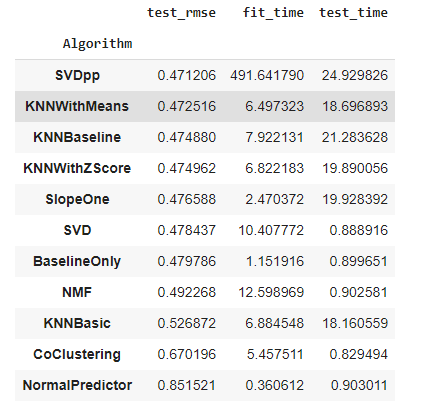

Aunque el algoritmo ***SVDpp*** es el que tiene mejor *rmse* (0.471206), sus tiempos son demasiado grandes.

Optamos por el algoritmo ***KNNWithMeans***, que aún teniendo un rmse un poco mayor (0.472516), es mucho más rápido en su ejecución

In [ ]:
## Definimos el algoritmo como KNNWithMeans
algorithm = KNNWithMeans()

In [ ]:
## Separamos el dataset en train y test
trainset, testset = train_test_split(data, test_size=0.25)

## Entrenamos nuestro modelo
algorithm.fit(trainset)

## Generamos las predicciones

predicciones = algorithm.test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


Generamos nuestro recomendador

In [93]:
def beer_advisor(user):
  ## Inicializamos la recomendación
  recom = []

  ## Generamos el listado de cervezas de nuesto usuario
  reviewed = reviews[reviews.review_profilename == user].beer_beerid.tolist()

  ## Generamos la lista de cervezas que no ha bebido nuestro usuario
  candidates = beers[~beers.beer_beerid.isin(reviewed)].beer_beerid.unique()

  ## Sobre cada cerveza para ver su score
  for beer in candidates:
     recom.append([beer, algorithm.predict(beer, user)[3]])
 
  ## Generamos nuestro data set de resultados, pardiendo de la tabla de cervezas recomendadas
  recom = (pd.DataFrame(recom, columns=["beer_beerid", "review_estimated"])
          ## ordenamos por el valor estimado
          .sort_values("review_estimated", ascending=False)
          ## unimos la información de las cervezas
          .merge(beers[["beer_beerid", "beer_name", "brewery_name", "beer_style"]], 
              on='beer_beerid')
          ## ERROR: salen algunos valores duplicados (no localizado el error)
          ## los quitamos del dataset final
          .drop_duplicates()                                                      
          )
  
  print("Estas son las diez recomendaciones de cervezas para el usuario \n" + '\033[1m' +  user + "\033[0m\n")
  ## Sacamos los 10 primeros
  return recom.head(10)
     

In [75]:
beer_advisor("stcules")


,beer_beerid,review_estimated,beer_name,brewery_name,beer_style
0,68665.0,5.000000,Lips Of Faith - Eric's Ale (Bourbon Barrel Aged),New Belgium Brewing,American Wild Ale
2,60069.0,5.000000,Sierra Nevada Oaked Imperial Porter,Sierra Nevada Brewing Co.,American Porter
3,24574.0,5.000000,Flander's Red,Coopersmith's Pub & Brewing,Flanders Red Ale
5,14252.0,5.000000,Bourbon Barrel Vermont Smoked Porter,The Vermont Pub & Brewery,American Porter
6,39026.0,5.000000,Pale Ale,New Belgium Brewing,American Pale Ale (APA)
7,57276.0,5.000000,Humulus Lager With Simcoe Hops,The Bruery,American Double / Imperial Pilsner
9,3676.0,4.992252,'99 Wee Heavy Scotch Ale,The Vermont Pub & Brewery,Scotch Ale / Wee Heavy
10,72007.0,4.962192,Saisonnaire,Cambridge Brewing Company,Saison / Farmhouse Ale
11,74521.0,4.959594,Skull And Bones Foxy,Bristol Brewing Company,American Wild Ale
12,66290.0,4.957456,Rose De Cambrinus,Cambridge Brewing Company,American Wild Ale


Creamos un recomendador de usuarios aleatorios para comprobar su funcionamiento

In [78]:
import random

def beer_advisor_random():
  user = reviews['review_profilename'].iloc[random.randint(0,len(reviews))]
  return (beer_advisor(user))

In [102]:
beer_advisor_random()

Estas son las diez recomendaciones de cervezas para el usuario 
cvstrickland



,beer_beerid,review_estimated,beer_name,brewery_name,beer_style
0,25718.0,5.0,Lucidity,Port Brewing Company / Pizza Port,Saison / Farmhouse Ale
1,3676.0,5.0,'99 Wee Heavy Scotch Ale,The Vermont Pub & Brewery,Scotch Ale / Wee Heavy
2,19629.0,5.0,Old Engine 86,West Virginia Brewing Company,California Common / Steam Beer
3,40260.0,5.0,Blackberry-Juniper Wheat,West Virginia Brewing Company,Fruit / Vegetable Beer
4,22056.0,5.0,Jasper Murdock's Private Stock '04,"Jasper Murdock’s Alehouse, Dining Room & Micro...",English Barleywine
5,10793.0,5.0,Cauldron Brew,Caldera Brewing Company,American Strong Ale
6,8990.0,5.0,Celtic Red,Milwaukee Ale House,Irish Red Ale
7,43796.0,5.0,Banana Wheat,Walnut Brewery,American Pale Wheat Ale
8,42870.0,5.0,Batch 500,Lunar Brewing,American Double / Imperial IPA
9,34353.0,5.0,Barely Wine,Lunar Brewing,American Barleywine
